## Fully Convolutional Networks

Fully Convolutional Networks(FCNs) solve the problem of semantic segmentation by having the model first down-sample the image and then up-sample it to get an accurate semantic segmentation.

First the image of resolution h x w is convoluted to h/2 x w/2 and then to h/4 x h/4. Then the reverse operation is done using deconvolution and adding skip-connections. Skip connections are made to allow for up-sampling using a combination of combine coarse, high layer information and fine, low layer information.



In [59]:

%load_ext autoreload
%autoreload 2
import sys
import os
import pathlib

from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from torch.cuda.amp import GradScaler, autocast
import torchvision
from tqdm import tqdm
from torchinfo import summary
import time

debug = False

proj_notebooks_root = pathlib.Path().absolute()
proj_root_path = proj_notebooks_root.parent
data_path = proj_root_path / "data"

plt.rcParams.update({'axes.titlesize': 16})

print("Pytorch: \t", torch.__version__)
if (not debug) and torch.cuda.is_available():
    device='cuda'
    print('GPU:         \t', torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True
else:
    print("Device:     \t CPU")
    device='cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Pytorch: 	 1.10.1
GPU:         	 NVIDIA A100 80GB PCIe MIG 7g.79gb


## Initializing the dataset

The Brazilian NDTI dataset was created by Passos et al. using images from the
Brazilian National Department of Transport Infrastructure (NDTI). These images were captured using a Highway Diagnostic Vehicle with a fixed front facing 5MP camera. The camera is installed on the highest part of the vehicle, facing the front and with an inclination closer to orthogonality. The visibility of the pavement is 15 meters. The dataset was developed using these images after filtering out images which present a clear view of the pavement and have some crack(s) or pothole(s). 

The dataset is available at https://github.com/biankatpas/Cracks-and-Potholes-in-Road-Images-Dataset, so we download and untar it to our `data_path` directory.

In [3]:
base_dir = data_path / 'biankatpas' / 'Dataset'

if not base_dir.exists():
    dataset_url = 'https://github.com/biankatpas/Cracks-and-Potholes-in-Road-Images-Dataset/tarball/master'

    ! wget {dataset_url} -P {data_path}
    ! tar xvf {data_path / 'master'} -C {data_path}
    ! mv {data_path / 'biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054'} {data_path / 'biankatpas'}
    ! rm {data_path / 'master'}
else:
    print("Found the dataset")

Found the dataset


Each datapoint in the dataset consists of one image and 3 segmented masks: road, crack and pothole.

In [4]:
image_suffix = '_RAW.jpg'
segment_suffix = {
    'lane':'_LANE.png',
    'pothole':'_POTHOLE.png',
    'crack':'_CRACK.png',
}

def getSegment(directory, segm):
    segment = Image.open(directory / (directory.stem+segment_suffix[segm]))
    segment = np.array(segment)
    segment = segment[:,:,0]/255
    return segment

# Counting the number of directories and checking the number of files
# inside each. Also, the images are in slightly different dimensions.
# We shall account for this later.
f = [y for y in (base_dir).glob('*')] 
counts = {}
image_sizes = {}

for i in f:
    files = [y for y in i.glob('*')] 
    num = len(files)
    counts[num] = counts.get(num, 0) + 1
    image = Image.open(i/(i.stem+image_suffix))
    image_sizes[image.size] = image_sizes.get(image.size, 0) + 1
    
print(f"In {base_dir}:")
for count in counts:
    print(f"Found {counts[count]} dirs with {count} files each.")

print()

print(f"{'Resolution':<12}| {'Count':<10}")
print('-' * 23)
for i in image_sizes:
    print(f"{str(i):<12}| {image_sizes[i]:<10}")

In /home/default/workspace/roadsegm/data/biankatpas/Dataset:
Found 2235 dirs with 4 files each.

Resolution  | Count     
-----------------------
(1024, 630) | 1008      
(1024, 640) | 1227      


### Creating a custom dataset
By subclassing `torch.utils.data.Dataset`, I created a custom dataset which can handle custom transformations and load the data in the proper form. The `getAllSegments` function gets each segment and makes sure that all the categories are mutually exclusive for each pixel.

In [5]:
def getAllSegments(directory):
    segment_lane = getSegment(directory, 'lane')
    segment_crack = getSegment(directory, 'crack')
    segment_potholes = getSegment(directory, 'pothole')

    segment_crack = segment_crack - (segment_potholes)
    segment_crack = np.clip(segment_crack, 0,1)

    segment_lane = segment_lane - (segment_crack + segment_potholes)
    segment_lane = np.clip(segment_lane, 0,1)

    segment_bg = np.ones_like(segment_potholes) - (segment_lane + segment_crack + segment_potholes)
    segment_bg = np.clip(segment_bg, 0,1)

    segment_arrs = np.stack([segment_bg, segment_lane, segment_potholes, segment_crack], -1)
    return segment_arrs


class CracksDataset(torch.utils.data.Dataset):
    def __init__(self, files,image_transforms=None, both_transforms=None):
        self.files = files
        
        self.image_transforms = image_transforms
        self.both_transforms = both_transforms
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        chosenDir = self.files[idx]
        image = Image.open(chosenDir/(chosenDir.stem+image_suffix))
        segments = torch.Tensor(getAllSegments(chosenDir).transpose(2,0,1))
            
        if self.image_transforms is not None:
            image = self.image_transforms(image)
            
        if self.both_transforms is not None:
            image, segments = self.both_transforms(image, segments)
        
        return image, segments
        
numclasses = 4
class_names=['lanes', 'potholes', 'cracks']

### Custom Transformations

Some transformations need to be applied to both the image and the segments in an identical manner. I just wrote this custom `Compose` class and some transformations which will accept the image and the mask, and transform both.

The `RandomHorizontalFlipBoth` is a simple data augmentation method which increases the amount of training that can be achieved without additional data.

In [6]:
import torchvision.transforms.functional as F

class CenterCropBoth(torch.nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size

    def forward(self, img, mask):
        return F.center_crop(img, self.size), F.center_crop(mask, self.size)

class RandomHorizontalFlipBoth(torch.nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img, mask):
        if torch.rand(1) < self.p:
            return F.hflip(img), F.hflip(mask)
        return img, mask
    
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, *img):
        for t in self.transforms:
            img = t(*img)
        return img

data_transforms = {
    'both': Compose([                # This uses our custom Compose class
        CenterCropBoth((630, 1024)),
        RandomHorizontalFlipBoth()
    ]),
    'images': transforms.Compose([   # This uses the default torchvision.transforms.Compose
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Loading the data
The files are divided into test and train categories using a 8:2 ratio. Using these files, the dataset is created for each and finally, using the datasets, the dataloaders are initiated.

In [7]:
all_data = [y for y in (base_dir).glob('*')] 
random.shuffle(all_data)

train_count = len(all_data)*8//10

train_dataset = CracksDataset(all_data[:train_count],
                              image_transforms=data_transforms['images'], 
                              both_transforms=data_transforms['both'])

val_dataset = CracksDataset(all_data[train_count:],
                              image_transforms=data_transforms['images'], 
                              both_transforms=data_transforms['both'])

print(f"Created train_dataset with {len(train_dataset)} datapoints.")
print(f"Created val_dataset with {len(val_dataset)} datapoints.")

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=8)

Created train_dataset with 1788 datapoints.
Created val_dataset with 447 datapoints.


### Visualizing the batch

Here, we are just visualizing some images in the `train_dataloader` to ensure that the images and segments are being loaded properly.

Batch's image tensor size:  torch.Size([32, 3, 630, 1024])


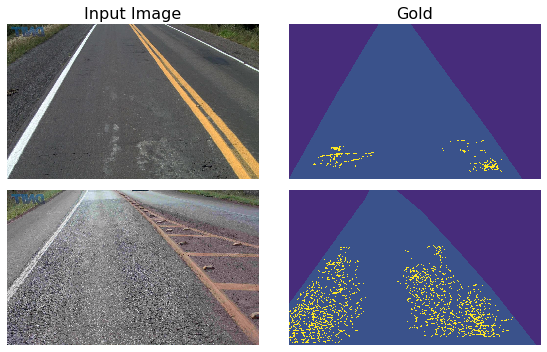

In [60]:
batch = next(iter(train_dataloader))
tensors = batch[0]
segments = batch[1]
print("Batch's image tensor size: ", tensors.shape)

# tensors, metadata
y = min(len(tensors)//2, 2)
x = 2
fig, axs = plt.subplots(y, x, 
                        sharey=True,
                        sharex=True,
                        tight_layout=True, 
                        figsize=(4*x, 2.5*y))

for i in range(y):
    ax = axs[i][0]
    if i == 0:
        ax.set_title('Input Image')
    image = tensors[i].permute(1,2,0).cpu().numpy()
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])
    ax.set_axis_off()
    ax.imshow(image)
    
    ax = axs[i][1]
    if i == 0:
        ax.set_title('Gold')
    res = segments[i][0] + \
            2 * segments[i][1] + \
            4 * segments[i][2] + \
            8 * segments[i][3]
    ax.set_axis_off()
    ax.imshow(res, cmap='viridis', interpolation='nearest', vmin=0, vmax=8)


## Training and Evaluation

The model is a very minimal one with just the [FCN model from pyTorch](https://pytorch.org/vision/main/models/generated/torchvision.models.segmentation.fcn_resnet50.html). I'm using the main output instead of `aux` everywhere. You could probably train more efficiently using the aux loss. Visit the pyTorch docs page for more details.

In [9]:
class SegModel(torch.nn.Module):

    def __init__(self, numclasses):
        super(SegModel, self).__init__()

        self.fcn = torchvision.models.segmentation.fcn_resnet50(
            pretrained = False, 
            num_classes = numclasses, 
            aux_loss = False,
            pretrained_backbone=True)

    def forward(self, x):
        x = self.fcn(x)['out']
        return x

The `get_eval_metrics` function below calculates the true positives (hits), false positives (shots-hits) and true negatives(targets-hits) from the `pred` and `gold` arguments. It thresholds the `pred` values to do this calculation. `torch.mul(pred,gold)` works to get the number of hits because the result will be 1 if both `pred` and `gold` are 1 for any particular pixel.

In [10]:
def get_eval_metrics(pred, gold, threshold = 0.5):
    pred = (pred > threshold).long()
    hits = torch.sum(torch.mul(pred,gold)).item() #element-wise multiplication
    shots = torch.sum(pred).item()
    targets = torch.sum(gold).item()
    return hits, shots, targets

accuracy_metrics = {}
for i in class_names:
    accuracy_metrics[i] = {'hits':0, 'shots':0, 'targets':0}

for i in range(len(class_names)):
    c = class_names[i]
    #Getting a random prediction
    random_pred = torch.rand_like(segments[:,i+1,:,:])
    hits, shots, targets = get_eval_metrics(random_pred, segments[:,i+1,:,:])
    accuracy_metrics[c]['hits'] += hits
    accuracy_metrics[c]['shots'] += shots
    accuracy_metrics[c]['targets'] += targets
    precision = 0.
    if shots > 0:
        precision = accuracy_metrics[c]['hits']/accuracy_metrics[c]['shots']
    accuracy_metrics[c]['precision'] = precision

    recall = 0.
    if targets > 0:
        recall = accuracy_metrics[c]['hits']/accuracy_metrics[c]['targets']
    accuracy_metrics[c]['recall'] = recall

    f1score = 0.
    if precision > 0 and recall > 0:
        f1score = (2 * precision * recall)/(precision + recall)
    accuracy_metrics[c]['f1score'] = f1score
    
for i in accuracy_metrics:
    print(f"{i:<8}  |   Precision: {accuracy_metrics[i]['precision']:8.5f}   Recall: {accuracy_metrics[i]['recall']:8.5f}  F1score: {accuracy_metrics[i]['f1score']:8.5f}")
    

lanes     |   Precision:  0.55120   Recall:  0.49986  F1score:  0.52427
potholes  |   Precision:  0.00293   Recall:  0.50263  F1score:  0.00583
cracks    |   Precision:  0.01237   Recall:  0.50072  F1score:  0.02415


The result of calculating evaluation metrics on a random state is as we expect. The recall is close to 0.5 and the precision is pretty low.

The training and testing loops are pretty standard. I am logging all the metrics into a dictionary called `history` which will be used to visualize the results later. 

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer, history, lr_sched = None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()
    bar_format = "{l_bar}{bar}| {elapsed}<{remaining} |{rate_fmt}{postfix}"
    
    total_loss = 0
    with tqdm(dataloader, unit="batch", desc='Training', bar_format=bar_format) as tepoch:
        for X, y in tepoch:
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            # Runs the forward pass with autocasting.
            with autocast():
                output = model(X)
                loss = loss_fn(output, y)

            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            # Backward passes under autocast are not recommended.
            # Backward ops run in the same dtype autocast chose for corresponding forward ops.
            scaler.scale(loss).backward()

            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
            # otherwise, optimizer.step() is skipped.
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()

            if(lr_sched is not None):
                lr_sched.step()

            total_loss += loss.item()
            tepoch.set_postfix(
                loss=round(loss.item(), 4), 
                lr=round(lr_sched.get_last_lr()[0], 4)
            )
        history['train_lr'].append(lr_sched.get_last_lr()[0])
        history['train_loss'].append(total_loss/num_batches)

    
def test_loop(dataloader, model, loss_fn, history):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss = 0

    accuracy_metrics = {}
    for i in class_names:
        accuracy_metrics[i] = {'hits':0, 'shots':0, 'targets':0}
    
    bar_format = "{l_bar}{bar}| {elapsed}<{remaining} |{rate_fmt}{postfix}"
    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Testing ", unit="batches", bar_format=bar_format):
            X = X.to(device)
            y = y.to(device)
            
            output = model(X)
                        
            for i in range(len(class_names)):
                c = class_names[i]
                hits, shots, targets = get_eval_metrics(output[:,i+1,:,:], y[:,i+1,:,:])
                accuracy_metrics[c]['hits'] += hits
                accuracy_metrics[c]['shots'] += shots
                accuracy_metrics[c]['targets'] += targets
    
    for category in accuracy_metrics:
        i = accuracy_metrics[category]
        shots = i['shots']
        hits = i['hits']
        targets = i['targets']
        precision = 0.
        if shots > 0:
            precision = i['hits']/i['shots']
        i['precision'] = precision
        
        recall = 0.
        if targets > 0:
            recall = i['hits']/i['targets']
        i['recall'] = recall
        
        f1score = 0.
        if precision > 0 and recall > 0:
            f1score = (2 * precision * recall)/(precision + recall)
        i['f1score'] = f1score
        
    loss /= num_batches
    history['test_loss'].append(loss)
    history['accuracy_metrics'].append(accuracy_metrics)
    

Finally, we are initializing the model, the optimizer(`SGD`), learning rate scheduler (`OneCycleLR`) and the loss function (`CrossEntropyLoss`). I am weighing the loss function here to give higher importance to classes 2 (potholes) and 3 (cracks) so that the model will have higher recall for these classes. I dont mind especially if the overall score drops a bit because of this.

In [63]:
model = SegModel(numclasses)
model.to(device)

epochs = 20

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.00001, momentum=0.9)

lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                       max_lr=0.01, 
                       steps_per_epoch=len(train_dataloader), 
                       epochs=epochs)

class_weights = torch.tensor([1,1,2,4]).to(device)
loss_fn = torch.nn.CrossEntropyLoss(class_weights)

summary(model, input_size=[32, 3, 630, 1024])

Layer (type:depth-idx)                             Output Shape              Param #
SegModel                                           --                        --
├─FCN: 1-1                                         [32, 4, 630, 1024]        --
│    └─IntermediateLayerGetter: 2-1                [32, 2048, 79, 128]       --
│    │    └─Conv2d: 3-1                            [32, 64, 315, 512]        9,408
│    │    └─BatchNorm2d: 3-2                       [32, 64, 315, 512]        128
│    │    └─ReLU: 3-3                              [32, 64, 315, 512]        --
│    │    └─MaxPool2d: 3-4                         [32, 64, 158, 256]        --
│    │    └─Sequential: 3-5                        [32, 256, 158, 256]       215,808
│    │    └─Sequential: 3-6                        [32, 512, 79, 128]        1,219,584
│    │    └─Sequential: 3-7                        [32, 1024, 79, 128]       7,098,368
│    │    └─Sequential: 3-8                        [32, 2048, 79, 128]       14,964,736
│   

### Running the training loop

In [13]:
# Creates a GradScaler once at the beginning of training.
scaler = GradScaler()

history = {
    'train_lr':[],
    'train_loss':[],
    'test_loss':[],
    'accuracy_metrics':[]
}

begin = time.time()
  
for epoch in range(epochs):
    print()
    print(f'Epoch {epoch+1}')
    print("-------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, history, lr_sched)
    test_loop(val_dataloader, model, loss_fn, history)
    print(f"Training Loss: {history['train_loss'][-1]:.5}\t    Testing Loss: {history['test_loss'][-1]:.5}")
    accuracy_metric = history['accuracy_metrics'][-1]
    for i in accuracy_metric:
        print(f"{i:<8}  |   Precision: {accuracy_metric[i]['precision']:8.5f}     Recall: {accuracy_metric[i]['recall']:8.5f}")

end = time.time()

# watch -d -n 0.5 nvidia-smi


Epoch 1
-------------


Training: 100%|██████████| 02:09<00:00 | 2.32s/batch, loss=0.258, lr=0.001 
Testing : 100%|██████████| 00:18<00:00 | 1.30s/batches


Training Loss: 0.57707	    Testing Loss: 0.0
lanes     |   Precision:  0.77344     Recall:  0.98146
potholes  |   Precision:  0.46154     Recall:  0.00035
cracks    |   Precision:  0.08883     Recall:  0.66878

Epoch 2
-------------


Training: 100%|██████████| 01:00<00:00 | 1.09s/batch, loss=0.184, lr=0.0028
Testing : 100%|██████████| 00:11<00:00 | 1.25batches/s


Training Loss: 0.20152	    Testing Loss: 0.0
lanes     |   Precision:  0.69779     Recall:  0.99856
potholes  |   Precision:  0.39787     Recall:  0.55440
cracks    |   Precision:  0.06496     Recall:  0.85056

Epoch 3
-------------


Training: 100%|██████████| 01:00<00:00 | 1.09s/batch, loss=0.138, lr=0.0052
Testing : 100%|██████████| 00:11<00:00 | 1.24batches/s


Training Loss: 0.15975	    Testing Loss: 0.0
lanes     |   Precision:  0.75411     Recall:  0.99931
potholes  |   Precision:  0.33566     Recall:  0.71436
cracks    |   Precision:  0.05998     Recall:  0.90332

Epoch 4
-------------


Training: 100%|██████████| 01:00<00:00 | 1.08s/batch, loss=0.134, lr=0.0076
Testing : 100%|██████████| 00:11<00:00 | 1.26batches/s


Training Loss: 0.14222	    Testing Loss: 0.0
lanes     |   Precision:  0.77309     Recall:  0.99920
potholes  |   Precision:  0.27049     Recall:  0.83551
cracks    |   Precision:  0.06095     Recall:  0.91380

Epoch 5
-------------


Training: 100%|██████████| 01:00<00:00 | 1.08s/batch, loss=0.129, lr=0.0094
Testing : 100%|██████████| 00:10<00:00 | 1.29batches/s


Training Loss: 0.13015	    Testing Loss: 0.0
lanes     |   Precision:  0.80494     Recall:  0.99943
potholes  |   Precision:  0.29609     Recall:  0.85912
cracks    |   Precision:  0.05535     Recall:  0.93950

Epoch 6
-------------


Training: 100%|██████████| 01:00<00:00 | 1.08s/batch, loss=0.0993, lr=0.01 
Testing : 100%|██████████| 00:11<00:00 | 1.26batches/s


Training Loss: 0.12169	    Testing Loss: 0.0
lanes     |   Precision:  0.83698     Recall:  0.99941
potholes  |   Precision:  0.31221     Recall:  0.84915
cracks    |   Precision:  0.05756     Recall:  0.94381

Epoch 7
-------------


Training: 100%|██████████| 01:00<00:00 | 1.09s/batch, loss=0.132, lr=0.0099 
Testing : 100%|██████████| 00:11<00:00 | 1.25batches/s


Training Loss: 0.11552	    Testing Loss: 0.0
lanes     |   Precision:  0.85279     Recall:  0.99923
potholes  |   Precision:  0.27922     Recall:  0.89710
cracks    |   Precision:  0.05472     Recall:  0.94476

Epoch 8
-------------


Training: 100%|██████████| 01:01<00:00 | 1.09s/batch, loss=0.0972, lr=0.0095
Testing : 100%|██████████| 00:11<00:00 | 1.25batches/s


Training Loss: 0.1102	    Testing Loss: 0.0
lanes     |   Precision:  0.84494     Recall:  0.99956
potholes  |   Precision:  0.30013     Recall:  0.89935
cracks    |   Precision:  0.05381     Recall:  0.95209

Epoch 9
-------------


Training: 100%|██████████| 01:00<00:00 | 1.09s/batch, loss=0.125, lr=0.0089 
Testing : 100%|██████████| 00:11<00:00 | 1.26batches/s


Training Loss: 0.10651	    Testing Loss: 0.0
lanes     |   Precision:  0.85900     Recall:  0.99942
potholes  |   Precision:  0.31092     Recall:  0.88628
cracks    |   Precision:  0.05281     Recall:  0.96374

Epoch 10
-------------


Training: 100%|██████████| 01:01<00:00 | 1.09s/batch, loss=0.081, lr=0.0081 
Testing : 100%|██████████| 00:11<00:00 | 1.24batches/s


Training Loss: 0.10311	    Testing Loss: 0.0
lanes     |   Precision:  0.86957     Recall:  0.99923
potholes  |   Precision:  0.28654     Recall:  0.91643
cracks    |   Precision:  0.05100     Recall:  0.96475

Epoch 11
-------------


Training: 100%|██████████| 01:00<00:00 | 1.08s/batch, loss=0.0839, lr=0.0072
Testing : 100%|██████████| 00:11<00:00 | 1.27batches/s


Training Loss: 0.10016	    Testing Loss: 0.0
lanes     |   Precision:  0.87535     Recall:  0.99921
potholes  |   Precision:  0.29399     Recall:  0.88806
cracks    |   Precision:  0.05038     Recall:  0.96735

Epoch 12
-------------


Training: 100%|██████████| 01:00<00:00 | 1.08s/batch, loss=0.0849, lr=0.0061
Testing : 100%|██████████| 00:11<00:00 | 1.26batches/s


Training Loss: 0.097392	    Testing Loss: 0.0
lanes     |   Precision:  0.87521     Recall:  0.99943
potholes  |   Precision:  0.32325     Recall:  0.88115
cracks    |   Precision:  0.05161     Recall:  0.96835

Epoch 13
-------------


Training: 100%|██████████| 01:00<00:00 | 1.08s/batch, loss=0.114, lr=0.005  
Testing : 100%|██████████| 00:11<00:00 | 1.21batches/s


Training Loss: 0.095668	    Testing Loss: 0.0
lanes     |   Precision:  0.87600     Recall:  0.99933
potholes  |   Precision:  0.29725     Recall:  0.90342
cracks    |   Precision:  0.05164     Recall:  0.97027

Epoch 14
-------------


Training: 100%|██████████| 01:01<00:00 | 1.09s/batch, loss=0.103, lr=0.0039 
Testing : 100%|██████████| 00:11<00:00 | 1.22batches/s


Training Loss: 0.09381	    Testing Loss: 0.0
lanes     |   Precision:  0.88352     Recall:  0.99929
potholes  |   Precision:  0.30600     Recall:  0.90312
cracks    |   Precision:  0.05007     Recall:  0.97248

Epoch 15
-------------


Training: 100%|██████████| 01:01<00:00 | 1.09s/batch, loss=0.115, lr=0.0028 
Testing : 100%|██████████| 00:11<00:00 | 1.22batches/s


Training Loss: 0.092417	    Testing Loss: 0.0
lanes     |   Precision:  0.88511     Recall:  0.99930
potholes  |   Precision:  0.31037     Recall:  0.90343
cracks    |   Precision:  0.05168     Recall:  0.97082

Epoch 16
-------------


Training: 100%|██████████| 01:00<00:00 | 1.08s/batch, loss=0.104, lr=0.0019 
Testing : 100%|██████████| 00:11<00:00 | 1.23batches/s


Training Loss: 0.091005	    Testing Loss: 0.0
lanes     |   Precision:  0.88497     Recall:  0.99930
potholes  |   Precision:  0.31384     Recall:  0.91454
cracks    |   Precision:  0.05158     Recall:  0.96981

Epoch 17
-------------


Training: 100%|██████████| 01:00<00:00 | 1.08s/batch, loss=0.0987, lr=0.0011
Testing : 100%|██████████| 00:11<00:00 | 1.26batches/s


Training Loss: 0.089741	    Testing Loss: 0.0
lanes     |   Precision:  0.89013     Recall:  0.99934
potholes  |   Precision:  0.31845     Recall:  0.91534
cracks    |   Precision:  0.05200     Recall:  0.96996

Epoch 18
-------------


Training: 100%|██████████| 01:00<00:00 | 1.08s/batch, loss=0.0825, lr=0.0005
Testing : 100%|██████████| 00:11<00:00 | 1.23batches/s


Training Loss: 0.08905	    Testing Loss: 0.0
lanes     |   Precision:  0.88536     Recall:  0.99939
potholes  |   Precision:  0.31373     Recall:  0.91738
cracks    |   Precision:  0.05141     Recall:  0.97216

Epoch 19
-------------


Training: 100%|██████████| 01:00<00:00 | 1.08s/batch, loss=0.0921, lr=0.0001
Testing : 100%|██████████| 00:11<00:00 | 1.24batches/s


Training Loss: 0.088495	    Testing Loss: 0.0
lanes     |   Precision:  0.88712     Recall:  0.99936
potholes  |   Precision:  0.30898     Recall:  0.91527
cracks    |   Precision:  0.05158     Recall:  0.97091

Epoch 20
-------------


Training: 100%|██████████| 01:00<00:00 | 1.08s/batch, loss=0.0853, lr=0     
Testing : 100%|██████████| 00:11<00:00 | 1.25batches/s


Training Loss: 0.088416	    Testing Loss: 0.0
lanes     |   Precision:  0.88794     Recall:  0.99935
potholes  |   Precision:  0.32127     Recall:  0.90070
cracks    |   Precision:  0.05130     Recall:  0.97122


### Calculating average metrics

I just macro-average the different classes' metrics to get the final metric. I do not micro-average because the lane and background classes have a much higher number of pixels so they would overshadow the more important metrics (cracks and potholes)

In [14]:
average_metrics = []
for entry in history['accuracy_metrics']:
    precision = 0
    recall = 0
#     print(entry)
    for category in entry:
        recall += entry[category]['recall']
        precision += entry[category]['precision']
    metrics = {}
    metrics['precision'] = precision = precision/len(entry)
    metrics['recall'] = recall = recall/len(entry)
    metrics['f1score'] = (2 * precision * recall)/(precision + recall)
    average_metrics.append(metrics)
average_metrics[-1]

{'precision': 0.42016984141101427,
 'recall': 0.9570870043404486,
 'f1score': 0.5839710959807975}

## Saving and Analysis

I usually save the training history and results so that I can compare how different runs fare against each other. I do this as a json. I also save the model to the `models_dir` path.

In [15]:
from datetime import datetime
import json 

#Saving the history and details of the training
run_details = {
    'desc':'42-FCN-Weighted-CrossEntropyLoss(maxlr-0.01)',
    'runtime':datetime.now().astimezone().strftime('%c'),
    'num_params': sum(p.numel() for p in model.parameters() if p.requires_grad),
    'lr_scheduler': r'OneCycleLR({})',
    'optimizer': 'SGD(momentum=0.9)',
    'loss_function':'CrossEntropy',
    'model':'fcn_resnet50',
    'time_taken':end-begin,
    'history':history,
    'average_metrics':average_metrics,
    'best_f1_score': max([i['f1score'] for i in average_metrics])
}

log_dir = proj_root_path / 'log'
if not log_dir.exists():
    log_dir.mkdir()

datestring = datetime.now().astimezone().strftime("%Y%m%d")

with open(log_dir/f"{datestring}-{run_details['desc']}", 'w') as fout:
    json_object = json.dumps(run_details, indent = 4) 
    fout.write(json_object)
    
#Saving the model
models_dir = proj_root_path / 'models'
if not models_dir.exists():
    models_dir.mkdir()

inf_model_name = f"{run_details['desc']}-inference.pth"
ent_model_name = f"{run_details['desc']}-entire.pth"
torch.save(model.state_dict(), models_dir / inf_model_name)
torch.save(model, models_dir / ent_model_name)

print (f"Model {run_details['desc']} saved to {models_dir.as_posix()}")


Model 42-FCN-Weighted-CrossEntropyLoss(maxlr-0.01) saved to /home/default/workspace/roadsegm/models


The f1-score for individual categories seem to be all over the place. This is because of the weights we assigned to our classes in our loss function. I was okay with these results because the recall scores were pretty high (and as we shall see, the results look pretty good). If you want a slightly different distribution of scores, you could caliberate the loss function a bit better.

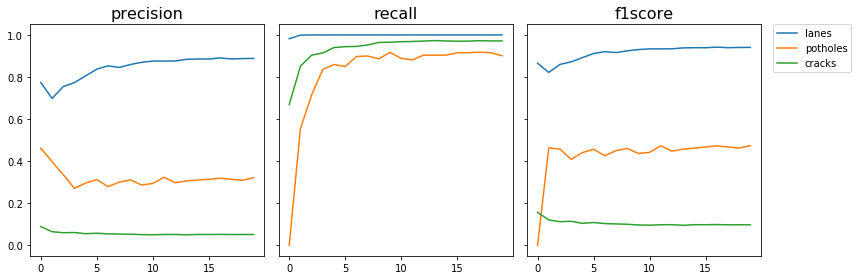

In [64]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(12,4))
accuracy_metrics = history['accuracy_metrics']
# We can set the number of bins with the *bins* keyword argument.
for i, metric in enumerate(['precision', 'recall','f1score']):
    for category in accuracy_metrics[0]:
        axs[i].plot([x[category][metric] for x in accuracy_metrics], label=f'{category}' )
        axs[i].set_title(metric)
plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)

## Visualizing the results

Finally, we use the model to predict the segments for a batch from the testing dataloader and visualize it.

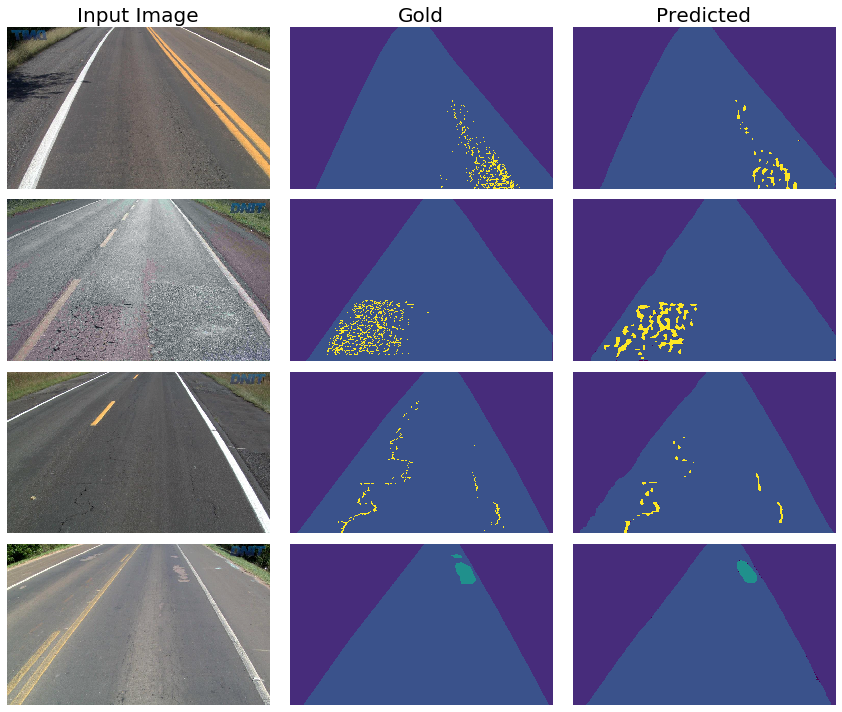

In [54]:
batch = next(iter(val_dataloader))
tensors = batch[0].to(device)
segments = batch[1]

with torch.no_grad():
    output = model(tensors).softmax(1)

y = min(len(tensors)//3, 4)
x = 3
fig, axs = plt.subplots(y, x, 
                        sharey=True, 
                        tight_layout=True, 
                        figsize=(4*x, 2.5*y))

for i in range(y):
    ax = axs[i][0]
    if i == 0:
        ax.set_title('Input Image')
    image = tensors[i].permute(1,2,0).cpu().numpy()
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])
    ax.set_axis_off()
    ax.imshow(image)
    
    #Plotting the gold image
    ax = axs[i][1]
    if i == 0:
        ax.set_title('Gold')
    res = segments[i][0] + \
            2 * segments[i][1] + \
            4 * segments[i][2] + \
            8 * segments[i][3]
    ax.set_axis_off()
    ax.imshow(res, cmap='viridis', interpolation='nearest', vmin=0, vmax=8)
    
    #Plotting the predicted image
    output_image = (output[i] > 0.5).float().cpu().numpy()
    ax = axs[i][2]
    if i == 0:
        ax.set_title('Predicted')
    res = output_image[0] + \
            2 * output_image[1] + \
            4 * output_image[2] + \
            8 * output_image[3]
    ax.set_axis_off()
    ax.imshow(res, cmap='viridis', interpolation='nearest', vmin=0, vmax=8)
    


As you can see, the model is quite good at predicting the segments of the particular dataset. However, the method doesnt seem to generalize well, in cases where the camera angle changes. Maybe it needs to be trained with more diverse data.

### Trying out the segmentation with some images from the RDD2020 dataset

In [25]:
cracks_dir = pathlib.Path("/home/default/workspace/cs6945share/cracks/rdd2020_exploded/val/images/")
crack_files = [y for y in (cracks_dir).glob('Japan*')] 

In [26]:
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.CenterCrop((300, 300))
])

In [28]:
# Getting some files and performing appropriate transformations

random.shuffle(crack_files)
chosen = crack_files[:9]
minibatch = []
for file in chosen:
    image = Image.open(file)
#     image
    image = transformations(image)
    minibatch.append(image)
minibatch = torch.stack(minibatch)
minibatch.shape

torch.Size([9, 3, 300, 300])

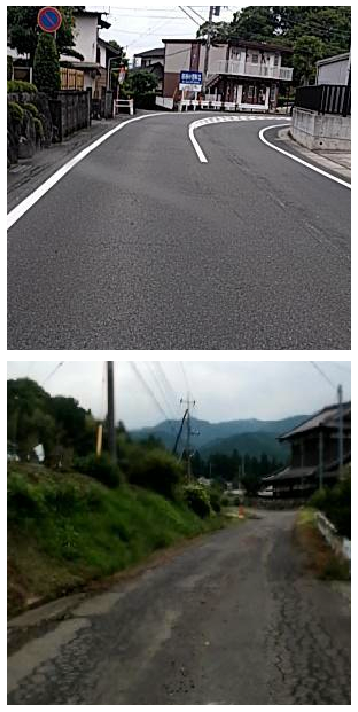

In [29]:
# Making sure our dataloaders are working fine

# tensors, metadata
y = min(len(minibatch)//2, 2)
x = 1
fig = plt.figure(figsize=(8*x, 5*y))

for i in range(y):
    ax = fig.add_subplot(y , x , (i) + 1)
    image = minibatch[i].permute(1,2,0).cpu().numpy()
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()

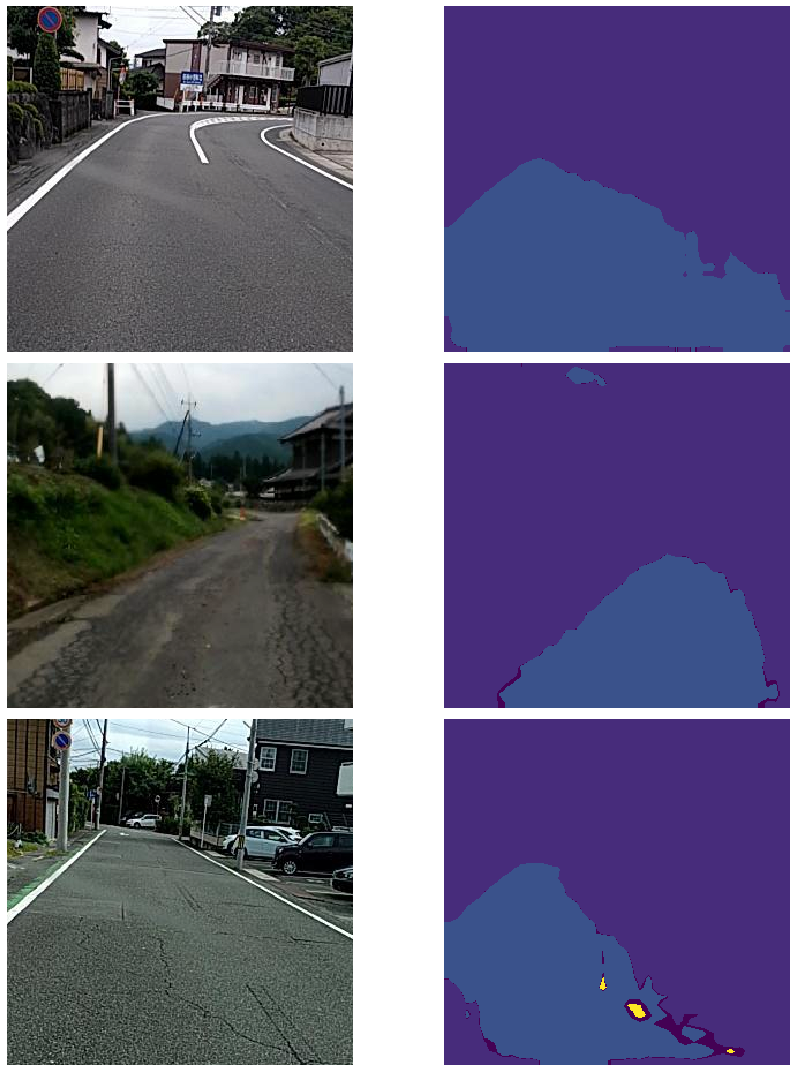

In [41]:
# Getting and visualizing the output

tensors = minibatch.to(device)

with torch.no_grad():
    output = model(tensors).softmax(1)

y = len(tensors)//3
x = 2
fig = plt.figure(figsize=(8*x, 5*y))

for i in range(y):
#     print(y*100 + x*10 + i)
    ax = fig.add_subplot(y , x , (i*2) + 1)
    image = tensors[i].permute(1,2,0).cpu().numpy()
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    
    output_image = (output[i] > 0.5).float().cpu().numpy()
    
#     output_image[1] = (0.5 * output_image[1]) + output_image[2]
#     output_image[2] = output_image[3]
    
    ax = fig.add_subplot(y , x , (i*2) + 2)
    res = output_image[0] + \
            2 * output_image[1] + \
            4 * output_image[2] + \
            8 * output_image[3]
    ax.set_axis_off()
    ax.imshow(res, cmap='viridis', vmin=0, vmax=8)
    plt.tight_layout()


It doesnt work well.